# Contents:
- combine six stocks and create a combined portfolio
- generate random portfolios with random weights on the three stocks to compute efficient frontiers
- calculate an optimal portfolio by selecting the portfolio with best sharpe ratio
- predict the portfolio weights using a RandomForest Regressor with exponentially weighted moving averages of prices
- compare return of predictions on portfolio with individual stock

# Tools:
- MPT, Sharpe Ratios
- RandomForestRegressor

# Impoer Package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams

plt.style.use('seaborn')
plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

from sklearn.ensemble import RandomForestRegressor

# Data

In [2]:
aapl = pd.read_csv('AAPL.csv')
aapl['Date'] = pd.to_datetime(aapl['Date'], format='%Y-%m-%d')
aapl.set_index(['Date'],inplace=True)
aapl = aapl[['Adj_Close']].loc['2013-02-21':'2018-01-31']
aapl['AAPL'] = aapl['Adj_Close']
aapl.drop(columns=['Adj_Close'], inplace=True)

In [3]:
amd = pd.read_csv('AMD.csv')
amd['Date'] = pd.to_datetime(amd['Date'], format='%Y-%m-%d')
amd.set_index(['Date'],inplace=True)
amd = amd[['Adj_Close']].loc['2013-02-21':'2018-01-31']
amd['AMD'] = amd['Adj_Close']
amd.drop(columns=['Adj_Close'], inplace=True)

In [4]:
smlv = pd.read_csv('SMLV.csv')
smlv['Date'] = pd.to_datetime(smlv['Date'], format='%Y-%m-%d')
smlv.set_index(['Date'],inplace=True)
smlv = smlv[['Adj_Close']].loc['2013-02-21':'2018-01-31']
smlv['SMLV'] = smlv['Adj_Close']
smlv.drop(columns=['Adj_Close'], inplace=True)

In [5]:
spy = pd.read_csv('SPY.csv')
spy['Date'] = pd.to_datetime(spy['Date'], format='%Y-%m-%d')
spy.set_index(['Date'],inplace=True)
spy = spy[['Adj_Close']].loc['2013-02-21':'2018-01-31']
spy['SPY'] = spy['Adj_Close']
spy.drop(columns=['Adj_Close'], inplace=True)

In [6]:
lng = pd.read_csv('LNG.csv')
lng['Date'] = pd.to_datetime(lng['Date'], format='%Y-%m-%d')
lng.set_index(['Date'],inplace=True)
lng = lng[['Adj_Close']].loc['2013-02-21':'2018-01-31']
lng['LNG'] = lng['Adj_Close']
lng.drop(columns=['Adj_Close'], inplace=True)

In [7]:
msft = pd.read_csv('MSFTPrices.csv')
msft['Date'] = pd.to_datetime(msft['Date'], format='%Y-%m-%d')
msft.set_index(['Date'],inplace=True)
msft = msft.loc['2013-02-21':'2018-01-31']
msft['MSFT'] = msft['Adjusted']

## Modern portfolio theory(MPT): efficient frontiers

## Join stock DataFrames and calculate returns

In [8]:
# Join 6 stock dataframes together
full_df = pd.concat([aapl, amd, smlv, lng, spy, msft['MSFT']], axis=1).dropna()

# Resample the full dataframe to monthly timeframe
monthly_df = full_df.resample('BMS').first()

# Calculate daily returns of stocks
returns_daily = full_df.pct_change()

# Calculate monthly returns of the stocks
returns_monthly = monthly_df.pct_change().dropna()
print(returns_monthly)

                AAPL       AMD      SMLV       LNG       SPY      MSFT
Date                                                                  
2013-03-01 -0.034950 -0.069231  0.000504  0.047006  0.011235  0.016733
2013-04-01 -0.003624  0.008264  0.037543  0.320416  0.030471  0.023613
2013-05-01  0.024201  0.319672  0.004701 -0.001790  0.014290  0.143656
2013-06-03  0.032870  0.229814  0.020168  0.048404  0.038350  0.095341
2013-07-01 -0.092075  0.035354 -0.003289 -0.014022 -0.013014 -0.034560
2013-08-01  0.115967 -0.070732  0.069600  0.012834  0.057635 -0.078289
2013-09-02  0.076939 -0.141732 -0.058999 -0.022603 -0.036740  0.013724
2013-10-01 -0.001269  0.180428  0.070166  0.202172  0.035168  0.053325
2013-11-01  0.065723 -0.142487  0.021679  0.141941  0.040569  0.058070
2013-12-02  0.066203  0.105740  0.025281  0.055130  0.024516  0.090391
2014-01-01  0.003447  0.079235  0.039006  0.050556  0.018708 -0.033550
2014-02-03 -0.093287 -0.156962 -0.042607 -0.008980 -0.047835 -0.018299
2014-0

## Calculate covariances for volatility

In [9]:
# Daily covariance of stocks (for each monthly period)
covariances = {}
rtd_idx = returns_daily.index
for i in returns_monthly.index:    
    # Mask daily returns for each month and year, and calculate covariance
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    
    # Use the mask to get daily returns for the current month and year of monthy returns index
    covariances[i] = returns_daily[mask].cov()

print(covariances[i])

          AAPL       AMD      SMLV       LNG       SPY      MSFT
AAPL  0.000103  0.000109  0.000018  0.000021  0.000033  0.000045
AMD   0.000109  0.000996  0.000004  0.000078  0.000057  0.000128
SMLV  0.000018  0.000004  0.000034  0.000022  0.000018  0.000010
LNG   0.000021  0.000078  0.000022  0.000224  0.000040  0.000024
SPY   0.000033  0.000057  0.000018  0.000040  0.000030  0.000040
MSFT  0.000045  0.000128  0.000010  0.000024  0.000040  0.000107


## Calculate portfolios

In [10]:
portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

# Get portfolio performances at each month
for date in sorted(covariances.keys()):
    cov = covariances[date]
    for portfolio in range(1000):
        weights = np.random.random(6)
        weights /= np.sum(weights) # /= divides weights by their sum to normalize
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)
        
print(portfolio_weights[date][0])

[0.01691581 0.05071178 0.30984663 0.28898202 0.09311014 0.24043363]


## Plot efficient frontier

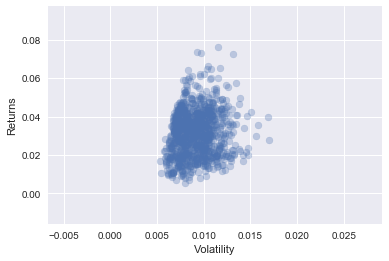

In [11]:
#use latest date from the covariances dictionary
date = sorted(covariances.keys())[-1] 

plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date],  alpha=0.3)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

# Sharpe ratios: features and targets

## Get best Sharpe ratios

In [12]:
# Empty dictionaries for sharpe ratios and best sharpe indexes by date
sharpe_ratio, max_sharpe_idxs = {}, {}

# Loop through dates and get sharpe ratio for each portfolio
for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
    
        # Divide returns by the volatility for the date and index, i
        sharpe_ratio.setdefault(date, []).append(ret / portfolio_volatility[date][i])

    # Get the index of the best sharpe ratio for each date
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])

print(portfolio_returns[date][max_sharpe_idxs[date]])

0.07343436835812883


## Calculate EWMAs
- EWMA: daily exponentially-weighted moving average as feature

In [13]:
# Calculate exponentially-weighted moving average of daily returns
ewma_daily = returns_daily.ewm(span=30).mean()

# Resample daily returns to first business day of the month with the first day for that month
ewma_monthly = ewma_daily.resample('BMS').first()

# Shift ewma for the month by 1 month forward so we can use it as a feature for future predictions 
ewma_monthly = ewma_monthly.shift(1).dropna()

print(ewma_monthly.iloc[-1])

AAPL    0.000992
AMD    -0.004848
SMLV    0.001337
LNG     0.001067
SPY     0.001504
MSFT    0.001836
Name: 2018-01-01 00:00:00, dtype: float64


## Make features and targets

In [14]:
targets, features = [], []

# Create features from price history and targets as ideal portfolio
for date, ewma in ewma_monthly.iterrows():

    # Get the index of the best sharpe ratio
    best_idx = max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx])
    features.append(ewma)  # add ewma to features

targets = np.array(targets)
features = np.array(features)
print(targets[-5:])

[[0.43632219 0.03150514 0.10682314 0.1210123  0.00705732 0.29727992]
 [0.05761641 0.02521977 0.32182001 0.14836588 0.3897181  0.05725983]
 [0.14770637 0.00273696 0.17200521 0.08593884 0.26521007 0.32640255]
 [0.00319073 0.0183085  0.31998819 0.01887064 0.52288053 0.11676141]
 [0.17999619 0.0056317  0.03713947 0.52233667 0.21513698 0.03975898]]


## Plot efficient frontier with best Sharpe ratio

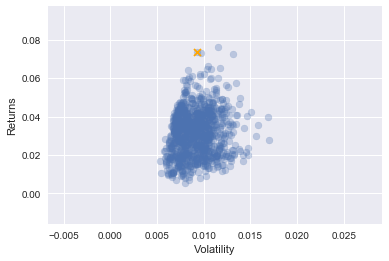

In [15]:
# Get most recent (current) returns and volatility
date = sorted(covariances.keys())[-1]

# Plot efficient frontier with sharpe as point
plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date], alpha=0.3)
best_idx = max_sharpe_idxs[date]

# Place an orange "X" on the point with the best Sharpe ratio
plt.scatter(x=portfolio_volatility[date][best_idx], y=portfolio_returns[date][best_idx], marker='x', color='orange')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

## Machine Learning for MPT

## Make predictions with a random forest

In [16]:
# Make train and test features
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

# Fit the model and check scores on train and test
rfr = RandomForestRegressor(n_estimators=300, random_state=42)
model_rfr = rfr.fit(train_features, train_targets)

## Get predictions and first evaluation

C:\Users\Thinkpad\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


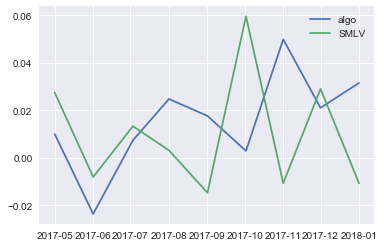

In [17]:
# Get predictions from model on train and test
train_predictions = model_rfr.predict(train_features)
test_predictions = model_rfr.predict(test_features)

# Calculate and plot returns from our RF predictions and the SPY returns
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)
plt.plot(test_returns, label='algo')
plt.plot(returns_monthly['SMLV'].iloc[train_size:], label='SMLV')
plt.legend()
plt.show()

## Evaluate returns
- set a starting value for our investment of $1000
- use the monthly returns from our portfolio selection and AMD and apply them to our starting cash balance. 
- get a month-by-month picture of how our investment is doing, and we can see how our predictions did overall vs the AMD 

algo returns: 0.14903032753095818
smlv returns: 0.08942176988360688


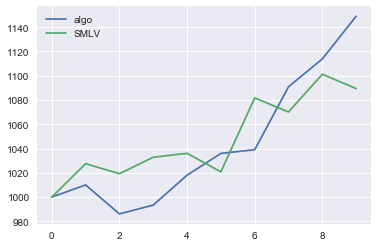

In [18]:
# Calculate the effect of our portfolio selection on a hypothetical $1k investment
cash = 1000
algo_cash, smlv_cash = [cash], [cash]  # set equal starting cash amounts
for r in test_returns:
    cash *= 1 + r
    algo_cash.append(cash)

# Calculate performance for smlv
cash = 1000  # reset cash amount
for r in returns_monthly['SMLV'].iloc[train_size:]:
    cash *= 1+r 
    smlv_cash.append(cash)

print('algo returns:', (algo_cash[-1] - algo_cash[0]) / algo_cash[0])
print('smlv returns:', (smlv_cash[-1] - smlv_cash[0]) / smlv_cash[0])

# Plot the algo_cash and spy_cash to compare overall returns
plt.plot(algo_cash, label='algo')
plt.plot(smlv_cash, label='SMLV')
plt.legend()  # show the legend
plt.show()